# Life Expectancy using Linear Regression
## Milestone 4: Unusual Observations


In [1]:
# import the necessary packages

import statsmodels.api as sm
# import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.stats.outliers_influence as sts
from patsy import dmatrices

import scipy.stats as stats
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Preliminary Exploratory Data Analysis

In [2]:
# Load the datafile from the previous milestone. 
# Use the column “State” for the index of the dataframe. 

df = pd.read_csv("./csv/state_data_clean.csv", index_col="State")

# Make the columns “Region” and “Division” categorical. 

df["Region"] = pd.Categorical(df["Region"], ordered=False)
df["Division"] = pd.Categorical(df["Division"], ordered=False)

# Define a new column “Income” that is the result of dividing “Income2017” by 1000.

df['Income'] = df['Income2017']/1000

# Check the uploaded file
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Alaska to Wyoming
Data columns (total 22 columns):
HSGradPer        48 non-null float64
BADegPer         48 non-null float64
AdvDegPer        48 non-null float64
LifeExp2018      48 non-null float64
MaleLifeExp      48 non-null float64
FemLifeExp       48 non-null float64
Pop              48 non-null float64
MurderNMTot      48 non-null int64
MurderTot        48 non-null float64
GunMurderTot     48 non-null float64
GunOwnPer        48 non-null float64
MurderNMRate     48 non-null float64
MurderRate       48 non-null float64
GunMurderRate    48 non-null float64
TotalKmQ         48 non-null int64
LandKmQ          48 non-null int64
WaterKmQ         48 non-null int64
Income2017       48 non-null int64
Abb              48 non-null object
Region           48 non-null category
Division         48 non-null category
Income           48 non-null float64
dtypes: category(2), float64(14), int64(5), object(1)
memory usage: 8.5+ KB


In [3]:
# Inspect the uploaded file
df.head()

,HSGradPer,BADegPer,AdvDegPer,LifeExp2018,MaleLifeExp,FemLifeExp,Pop,MurderNMTot,MurderTot,GunMurderTot,...,MurderRate,GunMurderRate,TotalKmQ,LandKmQ,WaterKmQ,Income2017,Abb,Region,Division,Income
State,,,,,,,,,,,,,,,,,,,,,
Alaska,92.4,29.0,10.4,78.8,76.7,81.2,738.0,59,57.0,39.0,...,7.7,5.3,1723337,1477953,245384,73181,AK,West,Pacific,73.181
Arizona,82.1,28.4,10.7,79.9,77.5,82.3,6818.0,306,278.0,171.0,...,4.1,2.5,295234,294207,1026,56581,AZ,West,Mountain,56.581
Arkansas,85.6,22.0,7.9,75.9,73.1,78.6,2978.0,181,164.0,110.0,...,5.5,3.7,137732,134771,2961,45869,AR,South,West South Central,45.869
California,82.5,32.6,12.2,81.6,79.4,83.8,38994.0,1861,1861.0,1275.0,...,4.8,3.3,423967,403466,20501,71805,CA,West,Pacific,71.805
Colorado,91.1,39.4,14.6,80.5,78.5,82.5,5449.0,176,176.0,115.0,...,3.2,2.1,269601,268431,1170,69117,CO,West,Mountain,69.117


In [4]:
df.describe()

,HSGradPer,BADegPer,AdvDegPer,LifeExp2018,MaleLifeExp,FemLifeExp,Pop,MurderNMTot,MurderTot,GunMurderTot,GunOwnPer,MurderNMRate,MurderRate,GunMurderRate,TotalKmQ,LandKmQ,WaterKmQ,Income2017,Income
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,4.800000e+01,4.800000e+01,48.000000,48.000000,48.000000
mean,88.593750,30.264583,11.327083,78.739583,76.443750,81.043750,6148.937500,294.625000,276.020833,197.145833,32.775000,4.503333,4.158333,2.897917,1.984846e+05,1.849454e+05,13539.312500,60193.458333,60.193458
std,3.527726,5.089894,2.737582,1.762341,1.915214,1.627412,7070.644896,347.436363,338.229526,241.554099,13.621986,2.195513,1.998492,1.695613,2.571958e+05,2.267155e+05,37587.988226,9850.680620,9.850681
min,76.700000,19.900000,7.800000,74.800000,71.900000,77.400000,586.000000,10.000000,10.000000,4.000000,5.200000,1.100000,1.100000,0.300000,4.001000e+03,2.678000e+03,497.000000,43469.000000,43.469000
25%,86.250000,26.975000,9.525000,77.950000,75.375000,80.150000,1794.000000,61.250000,57.000000,34.000000,25.300000,2.775000,2.675000,1.575000,9.365275e+04,8.956250e+04,1746.250000,53530.000000,53.530000
50%,89.550000,29.900000,10.750000,79.100000,76.800000,81.300000,4225.000000,179.500000,170.000000,114.000000,32.050000,4.350000,4.100000,2.800000,1.478705e+05,1.420305e+05,3706.500000,58882.500000,58.882500
75%,91.450000,33.100000,12.750000,79.900000,77.725000,81.950000,6903.500000,424.750000,396.000000,300.750000,42.500000,5.850000,5.350000,3.825000,2.212022e+05,2.120200e+05,10621.250000,68365.500000,68.365500
max,93.000000,42.100000,18.700000,82.300000,79.400000,85.300000,38994.000000,1861.000000,1861.000000,1275.000000,61.700000,10.300000,10.200000,8.100000,1.723337e+06,1.477953e+06,245384.000000,80776.000000,80.776000


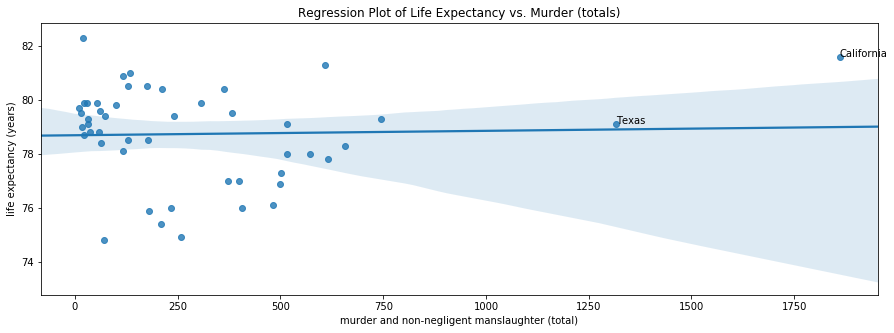

In [5]:
# Plot life expectancy against murder and non-negligent manslaughter (totals). 
# You will see that there are two states that stand apart on the x-axis. 
# These states are high-leverage points because they have an unusual combination of predictor values (in this case there is only one predictor: murder). 
# Re-run the plot annotating these states.

murder_data_num = df.loc[:,['LifeExp2018','MurderNMTot']]

fig, ax0 = plt.subplots(figsize=(15, 5))
sns.regplot(x = "MurderNMTot", y = "LifeExp2018", data=df, ax=ax0)
ax0.set(title = "Regression Plot of Life Expectancy vs. Murder (totals)", xlabel="murder and non-negligent manslaughter (total)", ylabel="life expectancy (years)")

# Annotate the 4 largest on the x-space
for state, murder in df.MurderNMTot.nlargest(2).items():
    lifeX = df.loc[state,'LifeExp2018']
    ax0.annotate(state,xy=(murder,lifeX))

plt.savefig("./img/regplot.png")    
plt.show()



In [6]:
# Order the Print the states that have unusual observations
df.MurderNMTot.nlargest(2)

State
California    1861
Texas         1316
Name: MurderNMTot, dtype: int64

Next you’ll check what happens when you eliminate "California".

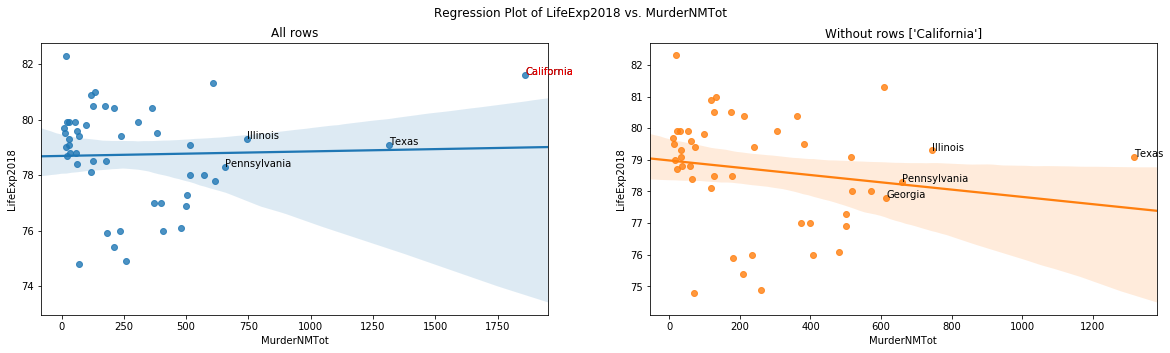

In [7]:
# Redo the last plot and add beside (or under) it the same plot but without "California". 
# In both plots annotate the largest four observations (on the x-axis). 
# In the first plot annotate also in red the observation/s that you will not consider in the second plot ("California"). 


x_col = 'MurderNMTot'
y_col = "LifeExp2018"
# retrieve the names of the 2 states with the highest value in the column "x_col"
rows_out = list(df[x_col].nlargest(1).index)
rows_subset = df.index.difference(rows_out)

# dataframe without the selected rows
df_subset = df.loc[rows_subset,:]

# do the plot

fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols= 2,  figsize=(20, 5))   

sns.regplot(x = x_col, y = y_col, data=df, ax=ax0)
ax0.set(title= "All rows")

# annotate the largest 4 observations (on te x-axis) in the first plot
for idx, x_val in df[x_col].nlargest(4).items():
    y_val = df.loc[idx,y_col]
    ax0.annotate(idx, xy=(x_val,y_val))

    
# annotate in red in the first plot the observations that will be deleted in the second plot
for idx in rows_out:
    x_val = df.loc[idx,x_col]
    y_val = df.loc[idx,y_col]
    ax0.annotate(idx, xy=(x_val,y_val), color = "red")

# second plot
sns.regplot(x = x_col, y = y_col, data=df_subset, ax=ax1)
ax1.set(title= "Without rows {}".format(rows_out))
fig.suptitle("Regression Plot of "+y_col+" vs. "+x_col)

# annotate the largest 4 observations (on the x__axis) in the second plot
for idx, x_val in df_subset[x_col].nlargest(4).items():
    y_val = df_subset.loc[idx,y_col]
    ax1.annotate(idx, xy=(x_val,y_val))

plt.show()

Do you see changes in the regression line in the second plot?   
You can see that when you don’t consider "California", the slope of the regression line changes (from going upwards to going downwards).

In [8]:
# You have seen visually that the slope of the regression line changes. 
# Now let’s inspect numerically if there are any changes. 
# Run two linear regression anaysis with and without "California"
# Here is a model for the first regression
# The analyst used the dmatrices function from the patsy API to prepare the dataframes

formula = y_col +' ~ ' + x_col

y0, X0 = dmatrices(formula, data=df, return_type='dataframe')
mod0 = sm.OLS(y0, X0)    # Describe model
mod0 
fit0 = mod0.fit()       # Fit model
print('Model parameters for regression: '+ y_col + ' ~ ' + x_col)
print('With all rows:')
print(fit0.params.apply(lambda x: "{:.8f}".format(x)))   

y1, X1 = dmatrices(formula, data=df_subset, return_type='dataframe')
mod1 = sm.OLS(y1, X1)    # Describe model
fit1 = mod1.fit()       # Fit model
print('Without rows {}:'.format(rows_out))
print(fit1.params.apply(lambda x: "{:.8f}".format(x))) 

# Compare the coefficients from both regressions. 

Model parameters for regression: LifeExp2018 ~ MurderNMTot
With all rows:
Intercept      78.69142768
MurderNMTot     0.00016345
dtype: object
Without rows ['California']:
Intercept      78.97967875
MurderNMTot    -0.00115177
dtype: object


Compare the coefficients from both regressions.   
We could see in the first regression plot that the slope of the regression line went upwards while in the second regression plot it went downwards.  
Now we see the exact amount of change in the regression coefficients of MurderNMTot, confirming what we saw before graphically.



Now pack the regression plots and analyses in a function.

In [9]:
def unusual_obs_analysis(rows_out, x, y, data):
    """ Prints plots and statistics of unusual observations
    
    Parameters
    ----------
    rows_out: list of rows to delete in the second plot
    x: predictor
    y: response
    data: dataframe
    
    Returns
    -------
    fig, (ax0, ax1)
    
    """

    # do the regression plots
    fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols= 2,  figsize=(20, 5))   
    
    # first plot with all the rows in ax0
    sns.regplot(x = x, y = y, data=data, ax=ax0)
    ax0.set(title= "All rows")

    # annotate the largest 4 observations (on the x-axis) in the first plot
    for idx, x_val in data[x].nlargest(4).items():
        y_val = data.loc[idx,y]
        ax0.annotate(idx, xy=(x_val,y_val))

    # annotate in red in the first plot the observations that will be deleted in the second plot
    for idx in rows_out:
        x_val = data.loc[idx,x]
        y_val = data.loc[idx,y]
        ax0.annotate(idx, xy=(x_val,y_val), color = "red")

    # second plot without the rows in *rows_out*
    # compute the rows that are not in rows_out
    rows_subset = df.index.difference(rows_out)

    # define dataframe without rows in rows_out
    data_subset = data.loc[rows_subset,:]

    # second plot without the rows in rows_out in ax1
    sns.regplot(x = x, y = y, data=data_subset, ax=ax1)
    ax1.set(title= "Without rows {}".format(rows_out))

    fig.suptitle("Regression Plot of "+ y + " vs. "+ x)

    # annotate the largest 4 observations in the second plot
    for idx, x_val in data_subset[x].nlargest(4).items():
        y_val = data_subset.loc[idx,y]
        ax1.annotate(idx, xy=(x_val,y_val))

    plt.show()

    # Do 2 regressions: with and without the rows in rows_out
    
    formula = y +' ~ ' + x
    y0, X0 = dmatrices(formula, data=data, return_type='dataframe')
    mod0 = sm.OLS(y0, X0)    # Describe model
    fit0 = mod0.fit()       # Fit model
    print('Model parameters for regression: '+formula)
    print('With all rows')
    print(fit0.params.apply(lambda x: "{:.8f}".format(x)))   

    y1, X1 = dmatrices(formula, data=data_subset, return_type='dataframe')
    mod1 = sm.OLS(y1, X1)    # Describe model
    fit1 = mod1.fit()       # Fit model
    print('Without rows {}:'.format(rows_out))
    print(fit1.params.apply(lambda x: "{:.8f}".format(x))) 
  
        
    return fig, (ax0, ax1)

Now you’ll use the function to check if both "California" and "Texas" have the same impact in the coefficients of the regression.   
Run the function two times, the first time taking away "California", the second time taking away "Texas"
You will see that one of these observations has a much bigger impact in the coefficients.   

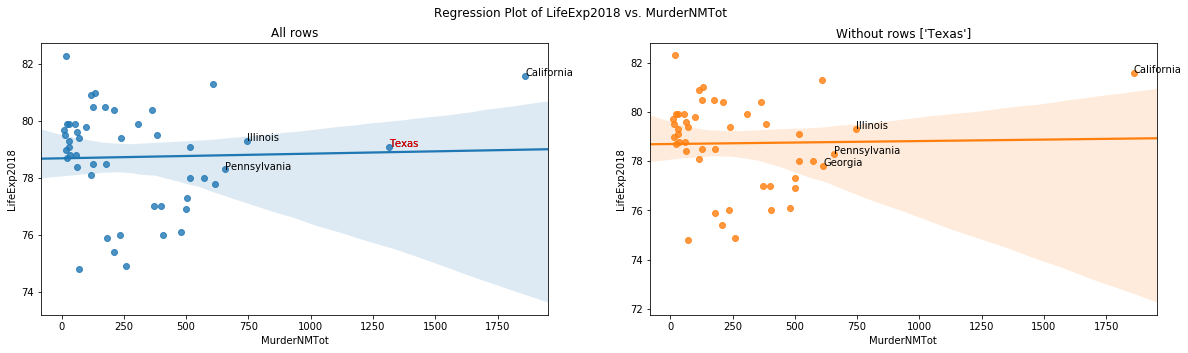

Model parameters for regression: LifeExp2018 ~ MurderNMTot
With all rows
Intercept      78.69142768
MurderNMTot     0.00016345
dtype: object
Without rows ['Texas']:
Intercept      78.69926288
MurderNMTot     0.00011965
dtype: object


In [10]:
# Texas is a high-leverage point
fig, (ax0, ax1) = unusual_obs_analysis(['Texas'],x = 'MurderNMTot', y = 'LifeExp2018', data = df)

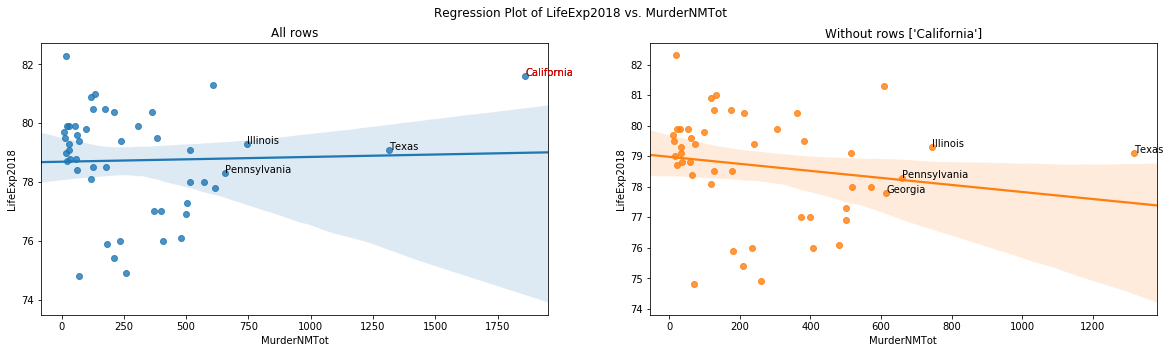

Model parameters for regression: LifeExp2018 ~ MurderNMTot
With all rows
Intercept      78.69142768
MurderNMTot     0.00016345
dtype: object
Without rows ['California']:
Intercept      78.97967875
MurderNMTot    -0.00115177
dtype: object


In [11]:
# California is a high-leverage point and an outlier
fig, (ax0, ax1) = unusual_obs_analysis(['California'],x = 'MurderNMTot', y = 'LifeExp2018', data = df)

Do both observations have the same impact in the coefficients? 
No, they don't. When we eliminated only "Texas", the slope of the line changed very slightly from 0.00016345 to 0.00011965. When we didn't consider "California", the slope changed from positive (0.00016345) to negative (-0.00115177). 

Both 'California' and 'Texas' are *high-leverage points*. They are unusual values in the predictor space (in this case, they have an unusual MurderNMTot value).   
But only California is an *outlier* (it is not well predicted by the model). California is also an *influential observation*. It unduly influences our regression results: the slope goes from positive to negative. 


## 2. High-leverage points

In the previous item of this milestone, you identified high-leverage points informally looking for observations that visually stand apart.   
Now you are going to do the same but formally, using the hat statistic. The hat value is a measure of the distance of an observation with respect to the centroid of the observations.    
You will consider observations that have 2 or 3 times the average hat value worth being examined.  
The hat values are stored in the property *hat_matrix_diag* of the *OLSInfluence object*.

In [12]:
def hat_values_plot(fit):
    """ Prints hat values plot
    Parameters
    ----------
    fit: fitted model
    
    Returns
    -------
    plot as fig, ax

    h_bar = p/n : mean hat value
    Observations whose hat values are >= 2 * h_bar are annotated
    p: number of parameters estimated in the model (including the intercept)
    n: sample size
    """
    # number of regressors + 1
    p = len(fit.params)
    # number of observations
    n = len(fit.fittedvalues)
    # mean hat value
    mean_hat = p/n
    # get OLSInfluence Object
    influence_obj = fit.get_influence()
    # retrieve hat values
    hat_values = influence_obj.hat_matrix_diag # get the hat values from the OLSInfluence object
    hat_values_series = pd.Series(hat_values, index = fit.resid.index, name='HatValues')
    fig, ax0 = plt.subplots(figsize = (15,9))
    ax0.set(title="Index Plot of Hat Values")
    ax0.axhline(y=mean_hat, color='b', linestyle='dotted', linewidth=1, label = "mean hat")
    ax0.axhline(y=2*mean_hat, color='g', linestyle='--', linewidth=1, label = "mean hat * 2")
    ax0.axhline(y=3*mean_hat, color='r', linestyle='--', linewidth=1, label = "mean hat * 3")
    markerline, stemlines, baseline = ax0.stem(hat_values_series.index,hat_values_series, linefmt = 'b-.', basefmt='None', use_line_collection=True)
    plt.xticks(rotation =90)
    # annotate hat values that >= 2 * mean_hat
    bound = 2 * mean_hat
    print("Hat values greater that bound: {:.4f}".format(bound))
    for id, val in hat_values_series.items():
        if val >= bound:
            ax0.annotate(id,xy=(id,val))
            print("{}: {:.2f}".format(id,val))
    ax0.legend()
    return fig, ax0

    

Hat values greater that bound: 0.0833
California: 0.45
Texas: 0.20


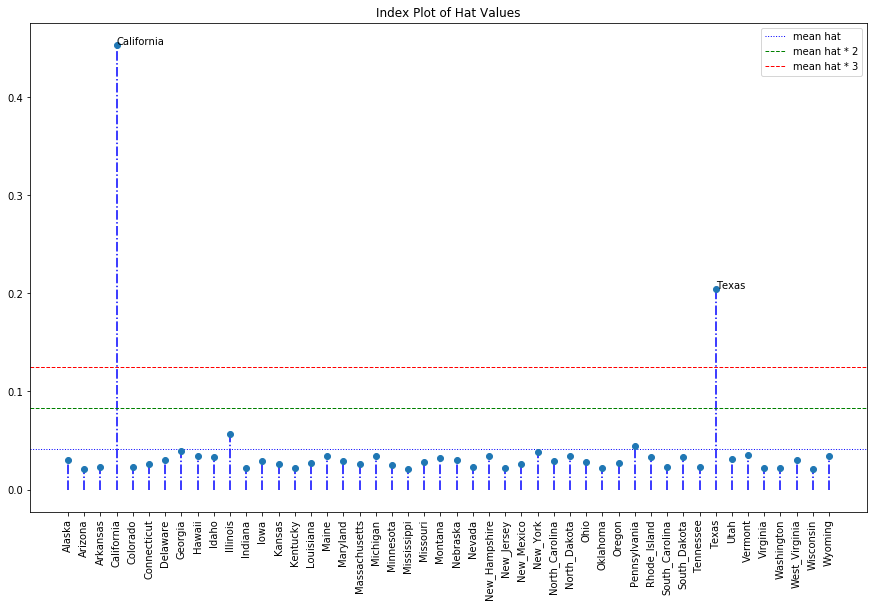

In [13]:
hat_values_plot(fit0)
plt.savefig("./img/hat_values.png")
plt.show()

As we have seen graphically before, Texas and California have unusual values in the predictor variable MurderNMTot.

## 3. Outliers

To detect outliers you are going to program a test that checks not the residuals, but the studentized residuals (a standarized version of the residuals).     
As a rule of thumb, you will consider an outlier any observation with a studentized residual larger than 2 or smaller than -2.   
The analyst working in the project had begun programming this function, but had left many to-dos. It is your task to finish the *check_outliers* function following to the docstring in the notebook.

Statsmodels has a class *OLSInfluence* to calculate outliers and influence measures from an *OLSResult*. 
You get an *OLSInfluence* object by applying the method *get_influence* to the *OLSResults* object that resulted from fitting the regression.    
There are two types of studentized residuals: external and internal. We are going to use the internal ones.  They are in the property resid_studentized-internal of the OLSResults object. 

In [14]:
def check_outliers(fit, bound = 2):
    """ Prints studentized redisuals whose absolute value exceed 2
    Parameters
    ----------
    fit: fitted model
    
    Returns
    -------
    nothing
    """
    influence_obj = fit.get_influence()
    student_resid = influence_obj.resid_studentized_internal
    student_resid_series = pd.Series(student_resid, index = fit.resid.index, name = 'StudentResid')
    print("Outliers\nStudentized residuals")
    for id, val in student_resid_series.items():
        if abs(val) >= bound:
            print(id, val)
    return

Run a regression of LifeExp2018 ~ MurderNMTot and check for outliers using the function

In [15]:
y, X0 = dmatrices('LifeExp2018 ~ MurderNMTot' , data=df, return_type='dataframe')
mod0 = sm.OLS(y, X0)    # Describe model
fit0 = mod0.fit()       # Fit model
check_outliers(fit0, 1.9)

Outliers
Studentized residuals
California 1.9783103595092284
Hawaii 2.060576645215972
Mississippi -2.1762653725751324
West_Virginia -2.225371420961975


Now you will examine visually if the outliers that you have found are also influential observations.   
Run the *unusual_obs_analysis* function for the outliers.   
Pay attention to the regression coefficients and look at the regression line to see if the slope has changed when that particular observation is not considered. 

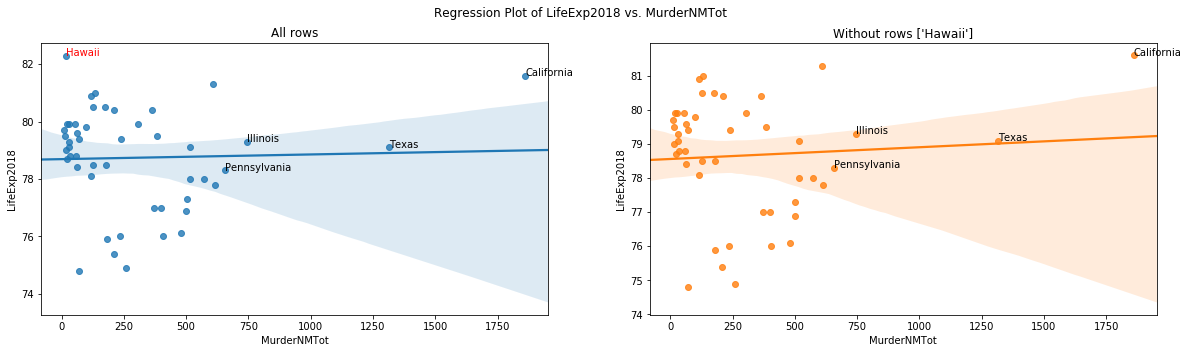

Model parameters for regression: LifeExp2018 ~ MurderNMTot
With all rows
Intercept      78.69142768
MurderNMTot     0.00016345
dtype: object
Without rows ['Hawaii']:
Intercept      78.56021716
MurderNMTot     0.00034481
dtype: object


In [16]:
# Hawaii is an outlier
fig, (ax0, ax1) = unusual_obs_analysis(['Hawaii'],x = 'MurderNMTot', y = 'LifeExp2018', data = df)

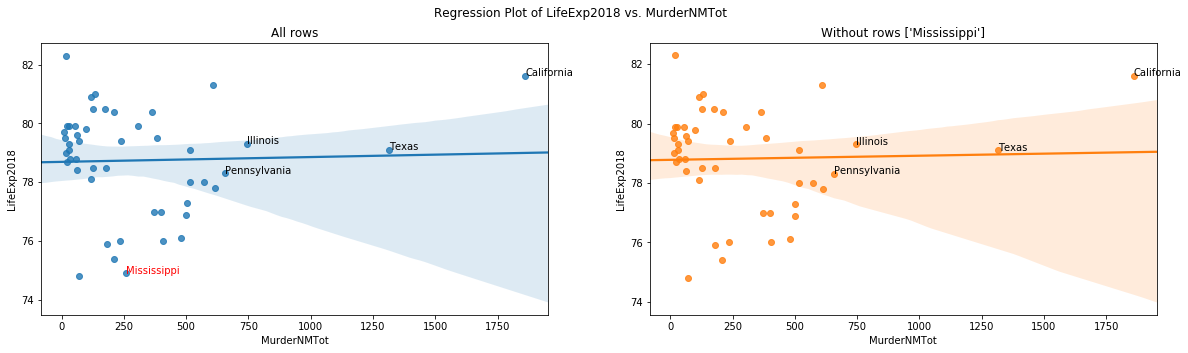

Model parameters for regression: LifeExp2018 ~ MurderNMTot
With all rows
Intercept      78.69142768
MurderNMTot     0.00016345
dtype: object
Without rows ['Mississippi']:
Intercept      78.78026078
MurderNMTot     0.00013886
dtype: object


In [17]:
# Mississippi is an outlier
fig, (ax0, ax1) = unusual_obs_analysis(['Mississippi'],x = 'MurderNMTot', y = 'LifeExp2018', data = df)

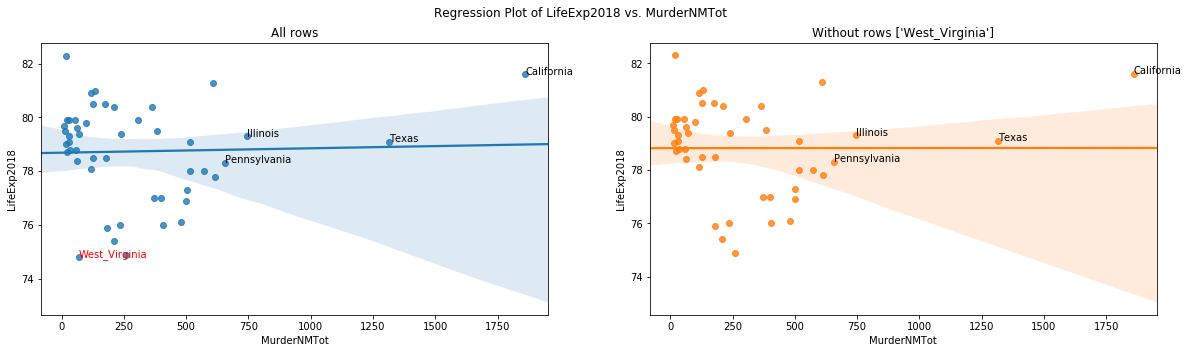

Model parameters for regression: LifeExp2018 ~ MurderNMTot
With all rows
Intercept      78.69142768
MurderNMTot     0.00016345
dtype: object
Without rows ['West_Virginia']:
Intercept      78.82214978
MurderNMTot     0.00000419
dtype: object


In [18]:
# West Virginia is an outlier
fig, (ax0, ax1) = unusual_obs_analysis(['West_Virginia'],x = 'MurderNMTot', y = 'LifeExp2018', data = df)

## 4. Influential observations

In the previous items you have analyzed visually if the observations were influential.   
Now you are going to do this task formally using the Cook's distance). This measure has a direct relation with the residuals and the hat statistic.   
You will consider influential  those observations with a Cook’s distance greater than 4/(n-p-2), where p is the number of parameters in the model (including the intercept) and n is the number of observations. 

Complete the function cooks_dist_plot to plot the Cook's distance. 


To detect influential observations, we are going to use the Cook's distance.
We have provided you with a function to plot the Cook's distance.

In [19]:
def cooks_dist_plot(fit):
    """ Prints a Cook's distance plot
    Parameters
    ----------
    fit: fitted model
    
    Returns
    -------
    plot as fig, ax

    p: number of parameters estimated in the model (including the intercept)
    n: sample size
    observations with a Cook's distance that exceeds 4/(n-p-2) should be annotated

    """

    p = len(fit.params)
    n = len(fit.fittedvalues)
    bound = 4/(n-p-2)

    # get OLSInfluence Object
    influence_obj = fit.get_influence()
    # get Cook's distances
    cooks_dist = influence_obj.cooks_distance[0] # get the cook's distances from the OLSInfluence object
    cooks_dist_series = pd.Series(cooks_dist, index = fit.resid.index, name='CookDist')
    # plot the distances
    fig, ax0 = plt.subplots(figsize = (15,9))
    ax0.set(title="Cook's Distance Plot")
    ax0.axhline(y=bound, color='g', linestyle='--', linewidth=1, label ="4/(n-k-1)")
    ax0.axhline(y=1, color='r', linestyle='--', linewidth=1, label ="1")
 
    markerline, stemlines, baseline = ax0.stem(cooks_dist_series.index,cooks_dist_series, linefmt = 'b-.', basefmt='None', use_line_collection=True)
    plt.xticks(rotation =90)
    # annotate values with Cook's distance >= bound
    print("Observations with Cook's distance greater that bound: {:.4f}".format(bound))
    for id, val in cooks_dist_series.items():
        if val >= bound:
            ax0.annotate(id,xy=(id,val))
            print("{}: {:.2f}".format(id,val))
    ax0.legend()
    return fig, ax0  

Observations with Cook's distance greater that bound: 0.0909
California: 1.62


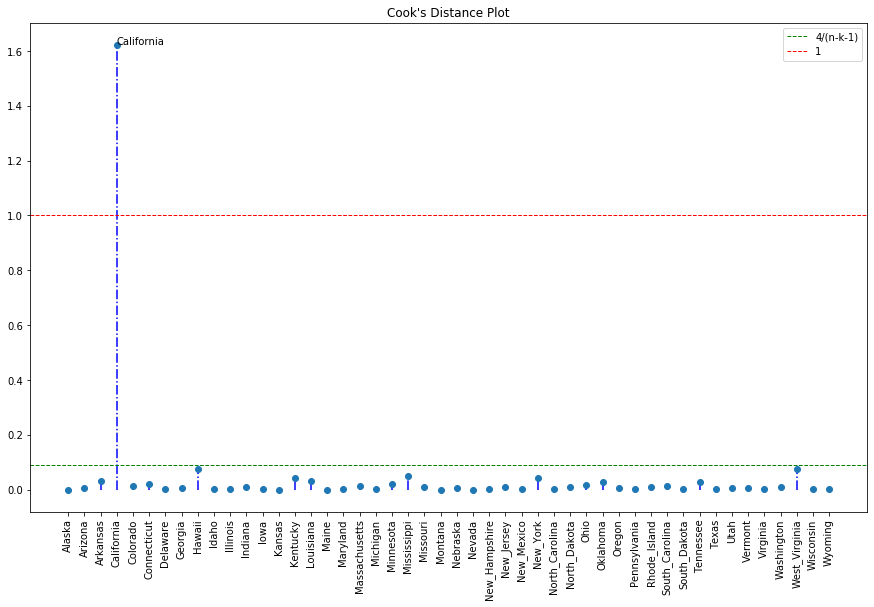

In [20]:
cooks_dist_plot(fit0)
plt.show()

The statsmodels library has an influence plot.  
Read the documentation and make an influence plot for 'LifeExp2018 ~ MurderNMTot’.   
Add to the plot three horizontal lines at -2, 0 and 2 and three vertical lines at the average hat value and at two and three times the average hat value.   

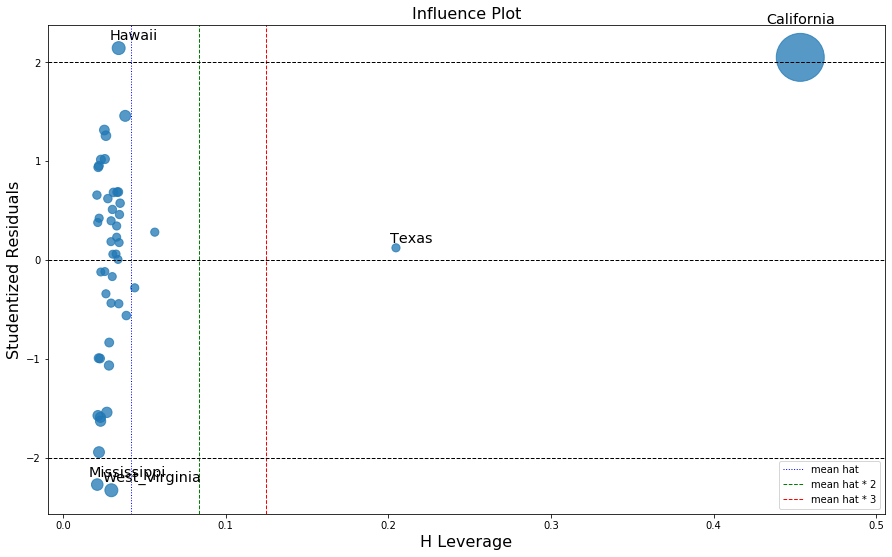

In [21]:
fig, ax0 = plt.subplots(figsize=(15, 9))
sm.graphics.influence_plot(fit0,  ax = ax0, criterion="Cooks")
# number of regressors + 1
p0 = len(fit0.params)
# number of observations
n0 = len(fit0.fittedvalues)
# mean hat value
mean_hat0 = p0/n0
ax0.axvline(x=mean_hat0, color='b', linestyle='dotted', linewidth=1, label = "mean hat")
ax0.axvline(x=2*mean_hat0, color='g', linestyle='--', linewidth=1, label = "mean hat * 2")
ax0.axvline(x=3*mean_hat0, color='r', linestyle='--', linewidth=1, label = "mean hat * 3")
ax0.axhline(y=2, color='black', linestyle='--', linewidth=1)
ax0.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax0.axhline(y=-2, color='black', linestyle='--', linewidth=1)
ax0.legend()
plt.show()

Do the results agree with what we have already found ?

The Cook's distances plot marked *California* as an influential observation. We see that on the size of point in the Influential Plot. California has both an extreme hat value and a big studentized residual.

*Texas* showed a big hat value and we see that again in the Influential Plot. But *Texas* has a studentized residual near 0, which greatly diminishes its influence. 

*Hawai*, *Mississippi*, and *West Virginia* were listed in the *check_outliers* function. In the Influence Plot we see that these states have studentized residuals with absolute values greater than 2. But their hat value is near the average hat value, so they don't have much influence.